# Ly$\alpha$ Luminosities

In [1]:
import sys
import glob
import numpy as np
import astropy.units as u
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import SymLogNorm
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from powerbox.powerbox import get_power
from hmf import MassFunction
from twentyonecmFAST import load_binary_data
from scipy.ndimage.filters import gaussian_filter

plt.rc('font', family='serif')

## Helpful Functions

In [2]:
def star_formation_rate(M, z = 7, sim_num = 1):
    '''
    Returns the star-formation rate for a dark-matter halo of a given mass and redshift
    
    Units: M_sun per year
    
    
    Note: Zero-out redshift for now. Other versions of this equation use redshift but the current
          sim that I am basing this equation off of does not use redshift.
    
    https://arxiv.org/pdf/1205.1493.pdf
    
    '''

    if sim_num == 1:
        a, b, d, c1, c2 = 2.8, -0.94, -1.7, 1e9, 7e10
        sfr = 2.8e-28 * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d
        
    if sim_num == 2:
        a, b, d, e, c1, c2, c3 = 2.59, -0.62, 0.4, -2.25, 8e8, 7e9, 1e11
        sfr = 1.6e-26 * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d * (1.0 + M / c3) ** e
        
    if sim_num == 3:
        a, b, d, e, c1, c2, c3 = 2.59, -0.62, 0.4, -2.25, 8e8, 7e9, 1e11
        sfr = 2.25e-26 * (1.0 + 0.075 * (z-7)) * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d * (1.0 + M / c3) ** e
    
    return sfr * u.M_sun / u.year

In [3]:
def f_lya(z, C_dust = 1.67, zeta = 2.57):
    '''
    Fraction of lyman-alpha photons not absorbed by dust
    
    https://arxiv.org/pdf/1010.4796.pdf
    '''
    return C_dust * 1e-3 * (1.0 + z) ** zeta

def f_esc(M,z):
    '''
    Escape fraction of ionizing photons
    '''
    def alpha(z):
        '''
        Alpha/beta values found in:

        https://arxiv.org/pdf/0903.2045.pdf
        '''
        zs = np.array([10.4,8.2,6.7,5.7,5.0,4.4])
        a = np.array([2.78e-2, 1.30e-2, 5.18e-3, 3.42e-3, 6.68e-5, 4.44e-5])
        b = np.array([0.105, 0.179, 0.244, 0.262, 0.431, 0.454])
        fa = interp1d(zs, a, kind = 'cubic')
        fb = interp1d(zs, b, kind = 'cubic')
        return (fa(z), fb(z))
    
    a, b = alpha(z)
    return np.exp(-a * M ** b)

def L_gal_rec(M, z, sim_num = 1):
    """
    Luminosity due to galactic recombinations
    """
    sf_rate = star_formation_rate(M, z = z, sim_num = sim_num)
    return 1.55e42 * (1 - f_esc(M, z)) * f_lya(z) * sf_rate * u.erg / u.s * u.year / u.Msun

def L_gal_exc(M, z, sim_num = 1):
    """
    Luminosity due to galactic excitations
    """
    sf_rate = star_formation_rate(M, z = z, sim_num = sim_num)
    return 4.03e41 * f_lya(z) * (1 - f_esc(M, z)) * sf_rate * u.erg / u.s * u.year / u.Msun

def L_gal(M, z, sim_num = 1):
    return L_gal_exc(M, z, sim_num = sim_num) + L_gal_rec(M, z, sim_num = sim_num)


def big_I(M, z, n = 256.):
    c = y(z) * cosmo.comoving_transverse_distance(z) ** 2 / (4 * np.pi * cosmo.luminosity_distance(z) ** 2)
    L_val = L_gal(M, z)
    V = (200. * u.Mpc / n) ** 3
    nu = 2.47e15 / u.s / (1 + z)
    return (nu * c * L_val / V).to(u.erg / u.cm ** 2 / u.s)

In [4]:
def H(z):
    '''
    Returns astropy Hubble constant at given redshift
    
    Units: km Mpc^-1 s^-1
    '''
    return cosmo.H(z)

def y(z):
    '''
    wl_lya -> Lyman-alpha wavelength in units of km
    
    Returns value in units of Mpc s
    '''
    l_lya = 1.215e-7 * u.m 
    return l_lya * (1.0 + z) ** 2 / H(z)

def I(z, L = L_gal, n = 5000, sim_num = 1):
    dlog10m = (13 - 8.) / n
    c = y(z) * cosmo.comoving_transverse_distance(z) ** 2 / (4 * np.pi * cosmo.luminosity_distance(z) ** 2)
    h = MassFunction(z = z, Mmin = 8, Mmax = 13, hmf_model = 'SMT', dlog10m = dlog10m)
    M = h.m * cosmo.h
    dM = np.diff(M)
    nu = 2.47e15 / u.s / (1 + z)
    dndm = h.dndm[1:] * u.Mpc ** -3
    nu_I = nu * np.sum(dndm * dM * L(M[1:], z, sim_num = sim_num) * c)
    return nu_I.to(u.erg / u.cm ** 2 / u.s)
    
def cube_3d_I(M, z, L = L_gal, n = 256):
    lya_field = np.zeros((n, n, n))
    I_vals = big_I(M, z, n = n).value
    lya_field[halo_pos[:, 0], halo_pos[:, 1], halo_pos[:, 2]] += I_vals
    return lya_field

In [87]:
def res_r(z, b):
    l_21 = (21. * u.cm) * (1 + z)
    return (1.22 * (l_21 / b)).to(u.dimensionless_unscaled) * u.radian

def g_filter_std(z, b, res, pix = 256, size = 200 * u.Mpc):
    theta = res(z, b)
    s = (cosmo.kpc_comoving_per_arcmin(z) * theta).to(u.Mpc)
    return np.round(s / size * pix, 2)

def res_lya(z, b = 20. * u.cm):
    l_lya = (1216. * u.Angstrom) * (1 + z)
    return (1.22 * (l_lya / b)).to(u.dimensionless_unscaled) * u.radian

In [88]:
def I_21(T, z):
    """
    Convert mean brightness temperature to a surface brightness
    """
    nu = 1420 * u.MHz / (z + 1)
    I = 2. * const.h * nu ** 3 / const.c ** 2 * 1.0 / (np.exp(const.h * nu / (const.k_B * T)) - 1)
    return (nu * I).to(u.erg / u.cm ** 2 / u.s)

In [124]:
z = 7.04
i_21 = g_filter_std(z, 282. * u.m, res_r).value
i_lya = g_filter_std(z, 20. * u.cm, res_lya).value

In [125]:
i_21, i_lya

(82.62, 0.07)

In [126]:
k_bins = 14

In [127]:
halos = np.loadtxt('../../data/halos_z7.04_768_200Mpc')
halo_pos = (halos[:, 1:] * 256).astype(int)
halo_mass = halos[:, 0]
idx = np.where(halo_pos[:, 2] == 127)[0]
lya_cube = cube_3d_I(halo_mass, z)

In [137]:
smooved_lya = gaussian_filter(lya_cube[:, :, :], i_lya)
ps_Lya, k_Lya = get_power(smooved_lya / smooved_lya.mean() - 1.0, 200, bins = k_bins, 
                          log_bins = True)
nu_I = I(z)

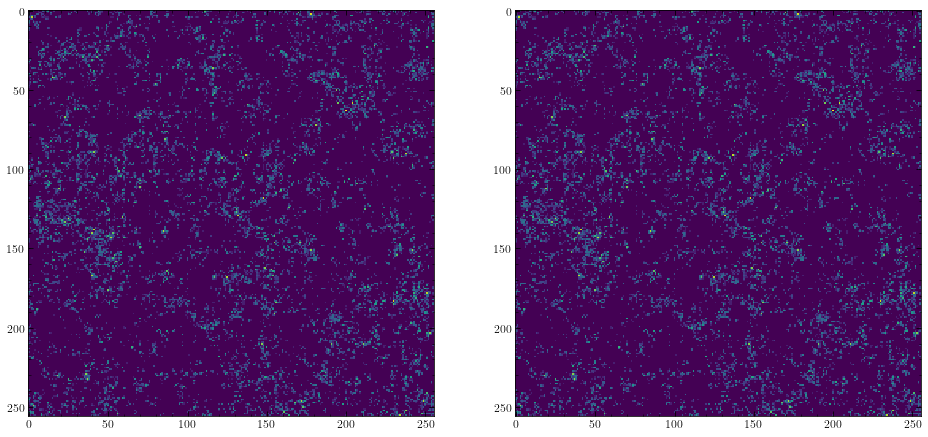

In [138]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(smooved_lya[:, :, 128], norm = SymLogNorm(linthresh = 1e-9))
plt.subplot(1,2,2)
plt.imshow(lya_cube[:, :, 128], norm = SymLogNorm(linthresh = 1e-9))
plt.show()

In [130]:
f = '../../data/delta_T_v3_z007.04_nf0.233584_useTs1_256_200Mpc'
data_cube = load_binary_data(f)
dc = data_cube.reshape((256,256,256))
smooved_21 = gaussian_filter(dc[:, :, :], i_21)

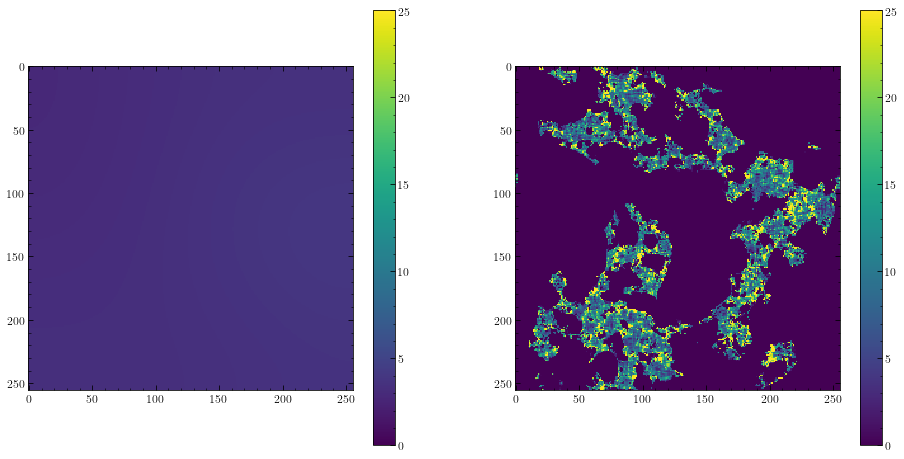

In [131]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(smooved_21[:, :, 128], vmin = 0, vmax = 25)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(dc[:, :, 128], vmin = 0, vmax = 25)
plt.colorbar()
plt.show()

In [132]:
ps_21, k_21 = get_power(smooved_21 / smooved_21.mean() - 1, 200, bins = k_bins, 
                               log_bins = True, dimensionless = True)

delta = k_21 ** 3 * ps_21 / (2 * np.pi ** 2)
delta_dim = I_21(dc.mean() * u.mK, z) ** 2 * delta

In [133]:
x_power, k = get_power(smooved_lya / smooved_lya.mean() - 1 , 200, 
                       deltax2 = smooved_21 / smooved_21.mean() - 1, log_bins = True, bins = k_bins)
delta_x = k ** 3 * x_power / (2 * np.pi ** 2)
delta_dim_x = I_21(dc.mean() * u.mK, z) * nu_I * delta_x

In [134]:
delta_lya = nu_I ** 2 * ps_Lya * k_Lya ** 3 / (2 * np.pi ** 2)

In [135]:
ccc_z = np.load('ccc_7.2.npy')
ks = np.load('ks.npy')

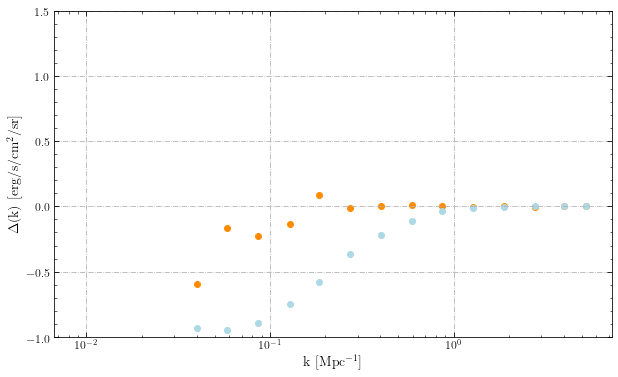

In [136]:
plt.figure(figsize = (10,6))
plt.scatter(k, delta_dim_x / np.sqrt(delta_dim * delta_lya), color = 'darkorange', label = 'Smoothed')
plt.scatter(ks, ccc_z, color = 'lightblue', label = 'Unsmoothed')
plt.ylim([-1, 1.5])
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$\Delta ({\rm k})$ [erg/s/cm$^2$/sr]')
plt.xscale('log')
plt.grid()
plt.show()

## Diffuse IGM

In [ ]:
def n_rec(x):
    """
    """
    return 